# **1. Alexnet**

. 이 모델은 8개의 레이어(5개의 합성곱 레이어와 3개의 완전 연결 레이어)로 구성되어 있으며, ReLU 활성화 함수, 드롭아웃(dropout), 데이터 증강(data augmentation) 등을 사용해 과적합을 방지하고 학습 성능을 향상시켰습니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2Fdcw1wn%2FbtsLNY2WjZf%2FAAAAAAAAAAAAAAAAAAAAAP7fPOYRu3K_vGkWg8DhH8_YK3QIw1BDmMrUdbFO-Kvf%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1753973999%26allow_ip%3D%26allow_referer%3D%26signature%3DhETqsS7NnN0njfPmJi5SNMw%252BZuE%253D'>

# **2. glasses vs. noglasses 분류하기**

In [2]:
%cd /content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data

/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data


In [3]:
!unzip -qq glass.zip

replace glass/test/glasses/row-1-column-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glass/test/glasses/row-1-column-10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# import 정리
import os
import torch
import glob
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

In [5]:
device = torch.device("cuda" if torch.cuda. is_available() else "cpu")
device

device(type='cuda')

In [29]:
# 여러 이미지를 중앙에서 잘라서 한 줄로 시각화
def display_images_center_crop(image_paths, title, max_images=4):

    plt.figure(figsize=(12, 3))

    for i, image_path in enumerate(image_paths[:max_images]):
        # 이미지 열기 및 크기 가져오기
        image = Image.open(image_path)
        width, height = image.size

        # 중앙 정사각형 영역 계산 (사용하지 않지만 참고용)
        new_edge_length = min(width, height)
        left = (width - new_edge_length) / 2
        top = (height - new_edge_length) / 2
        right = (width + new_edge_length) / 2
        bottom = (height + new_edge_length) / 2

        # 실제로 사용할 크롭: 가장자리 일정 픽셀 제거
        image_cropped = image.crop((10, 20, width-10, height-15))

        # 이미지 시각화
        plt.subplot(1, max_images, i + 1)
        plt.imshow(image_cropped)
        plt.title(title)
        plt.axis('off')
        plt.show()


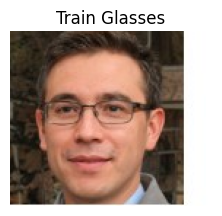

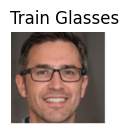

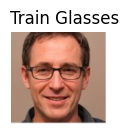

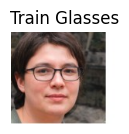

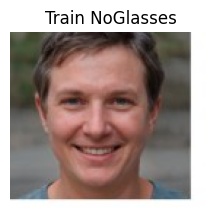

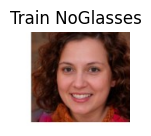

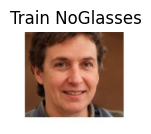

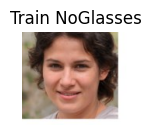

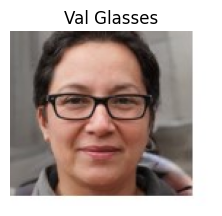

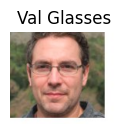

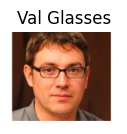

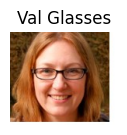

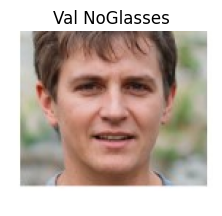

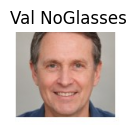

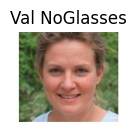

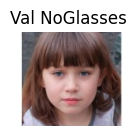

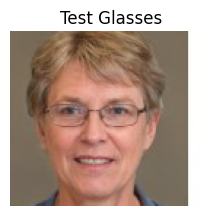

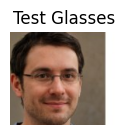

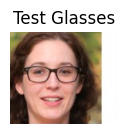

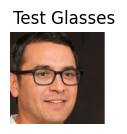

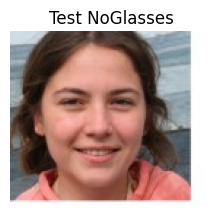

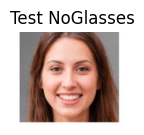

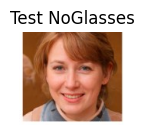

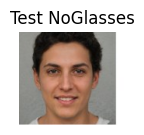

In [30]:
categories = ['Train Glasses', 'Train NoGlasses', 'Val Glasses', 'Val NoGlasses', 'Test Glasses', 'Test NoGlasses']

# glob: 파일 경로를 패턴으로 검색할 수 있게 해주는 함수
# 여러 이미지 카테고리별로 이미지 경로를 가져오기 위해 glob 모듈을 사용(자동 생성)
for category in categories:
    image_paths = glob.glob(f'/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/glass/{category.lower().replace(" ", "/")}/*')
    # print(image_paths)
    display_images_center_crop(image_paths, category)

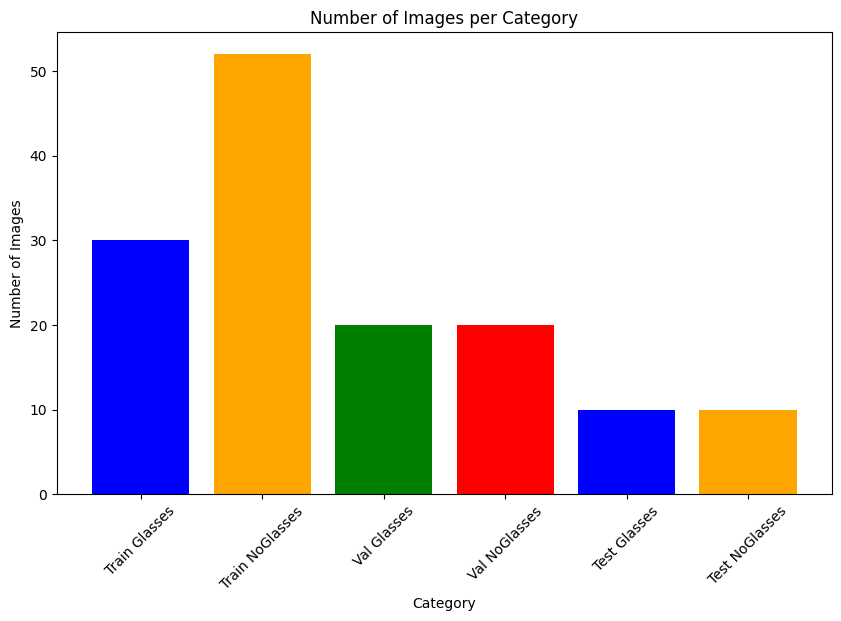

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/glass/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [21]:
transform = transforms.Compose([
    transforms.CenterCrop(128),  # 이미지 중앙을 기준으로 128*128 크기로 자름
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    # 밝기, 대비, 채도, 색조
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [32]:
train_dataset = ImageFolder('/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/glass/train', transform=transform)
val_dataset = ImageFolder('/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/glass/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [33]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()

        # Convolutional Layer
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding='same')

        # Max Pooling Layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)


    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))  # 입력이미지(x)에 conv1 필터를 적용해서 특징맵을 만들고, ReLU로 음수 값 제거
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(F.relu(self.conv5(x)))

        x = x.view(x.size(0), 256 * 6 * 6)
        # 합성곱 연산 이후의 출력을 완전연결층에 전달하기 위해 2차원으로 펼치는 작업
        # 0: 0차원으로 펼쳐짐.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [34]:
# 확인용
inputs = torch.Tensor(1, 3, 227, 227)
# print(inputs.shape)  # torch.Size([1, 3, 227, 227])

conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4)
out = conv1(inputs)
print(out.shape)  # torch.Size([1, 96, 55, 55])
maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
out = maxpool(out)
print(out.shape)  # torch.Size([1, 96, 27, 27])

torch.Size([1, 96, 55, 55])
torch.Size([1, 96, 27, 27])


In [35]:
model = AlexNet(num_classes=2)
model = model.to(device)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [38]:
# 정확도 계산 함수
def calculate_accuracy(loader, model):

    model.eval()  # 평가모드로 전환

    correct = 0
    total = 0

    with torch.no_grad():  # 기울기 계산 비활성화(역전파를 사용하지 않도록 설정)
        for data in loader:   # 데이터 로더에서 배치(images, labels가 들어있음) 가져오기
            images, labels = data  # 배치 데이터를 이미지와 정답 레이블로 분리
            images, labels = images.to(device), labels.to(device)  # 모델과 같은 장치로 데이터 이동
            outputs = model(images)  # 예측 수행
            _, predicted = torch.max(outputs.data, 1)  # 가장 높은 값의 인덱스 추출
            total += labels.size(0)  # 이번 배치의 총 이미지 개수만큼 누적
            correct += (predicted == labels). sum().item()  # .item(): 텐서를 숫자로 바꾸는 함수
        return correct * 100 / total


In [39]:
# 학습 및 검증 손실, 정확도 기록 리스트
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss=0.0

    # 학습 단계
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 순전파 → 손실 계산 → 역전파 → 파라미터 업데이트
        optimizer.zero_grad()
        outputs =model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 에포크별 평균 학습 손실 저장
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 검증 단계
    val_loss = 0.0
    model.eval()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # 에포크별 평균 검증 손실 저장
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # 검증 정확도 계산 및 저장
    val_accuracy = calculate_accuracy(val_loader, model)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val Acc: {val_accuracy:.6f}')
print("학습 및 검증 완료")

Epoch 1, Train Loss: 0.688805, Val Loss: 0.695295, Val Acc: 50.000000
Epoch 2, Train Loss: 0.667952, Val Loss: 0.715129, Val Acc: 50.000000
Epoch 3, Train Loss: 0.725240, Val Loss: 0.695385, Val Acc: 50.000000
Epoch 4, Train Loss: 0.677263, Val Loss: 0.696473, Val Acc: 50.000000
Epoch 5, Train Loss: 0.628188, Val Loss: 0.786941, Val Acc: 50.000000
Epoch 6, Train Loss: 0.527270, Val Loss: 0.810683, Val Acc: 50.000000
Epoch 7, Train Loss: 0.513444, Val Loss: 0.873713, Val Acc: 55.000000
Epoch 8, Train Loss: 0.426704, Val Loss: 1.509226, Val Acc: 55.000000
Epoch 9, Train Loss: 0.451079, Val Loss: 0.883780, Val Acc: 72.500000
Epoch 10, Train Loss: 0.511485, Val Loss: 0.825901, Val Acc: 55.000000
Epoch 11, Train Loss: 0.368893, Val Loss: 1.469790, Val Acc: 57.500000
Epoch 12, Train Loss: 0.414431, Val Loss: 1.161101, Val Acc: 57.500000
Epoch 13, Train Loss: 0.419501, Val Loss: 0.969665, Val Acc: 62.500000
Epoch 14, Train Loss: 0.446960, Val Loss: 1.635347, Val Acc: 55.000000
Epoch 15, Train

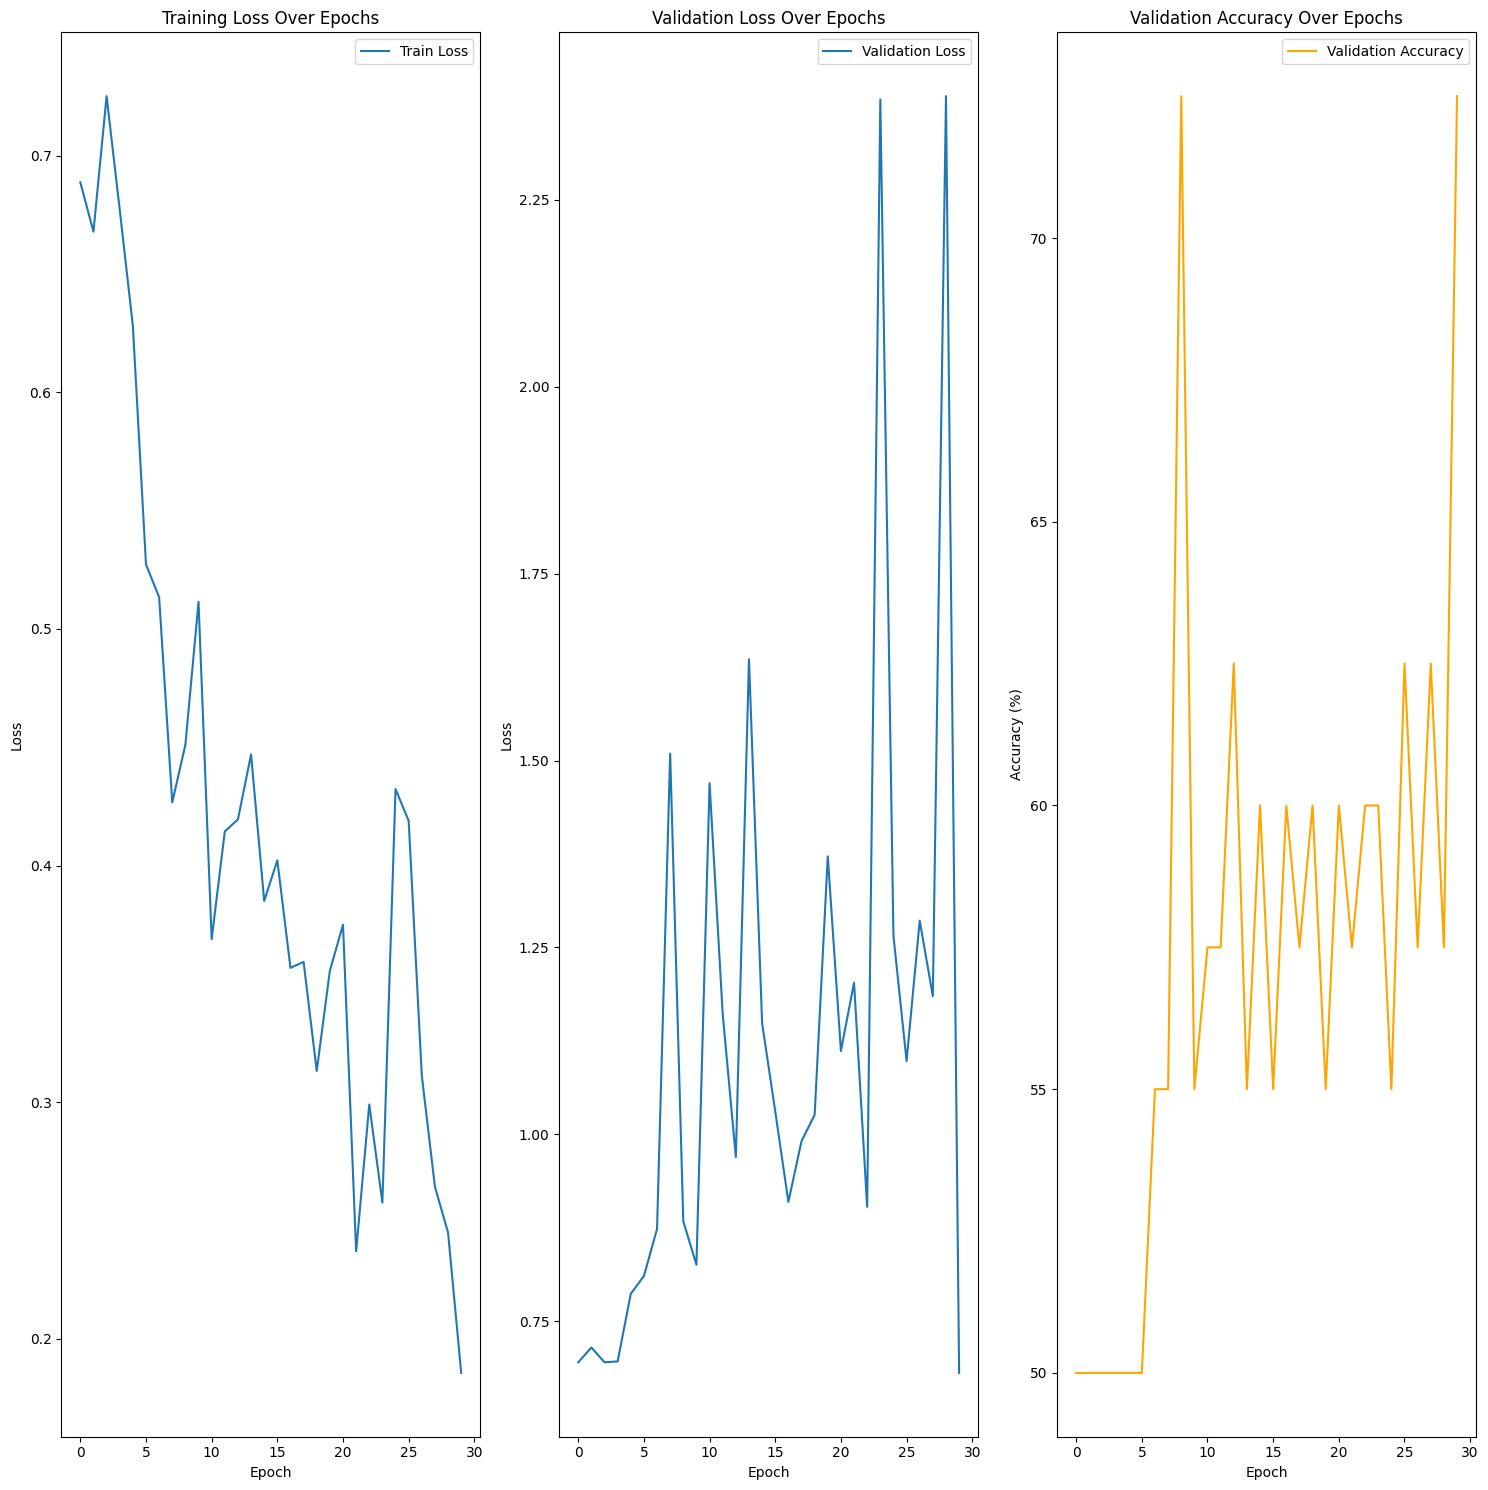

In [40]:
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    width, height = image.size

    # 중앙에서 128x128 영역을 잘라내기 위한 사각형 영역
    left = (width - 128) / 2
    top = (height - 128) / 2
    right = (width + 128) / 2
    bottom = (height + 128) / 2

    image_cropped = image.crop((left, top, right, bottom))
    return transform(image_cropped), image_cropped

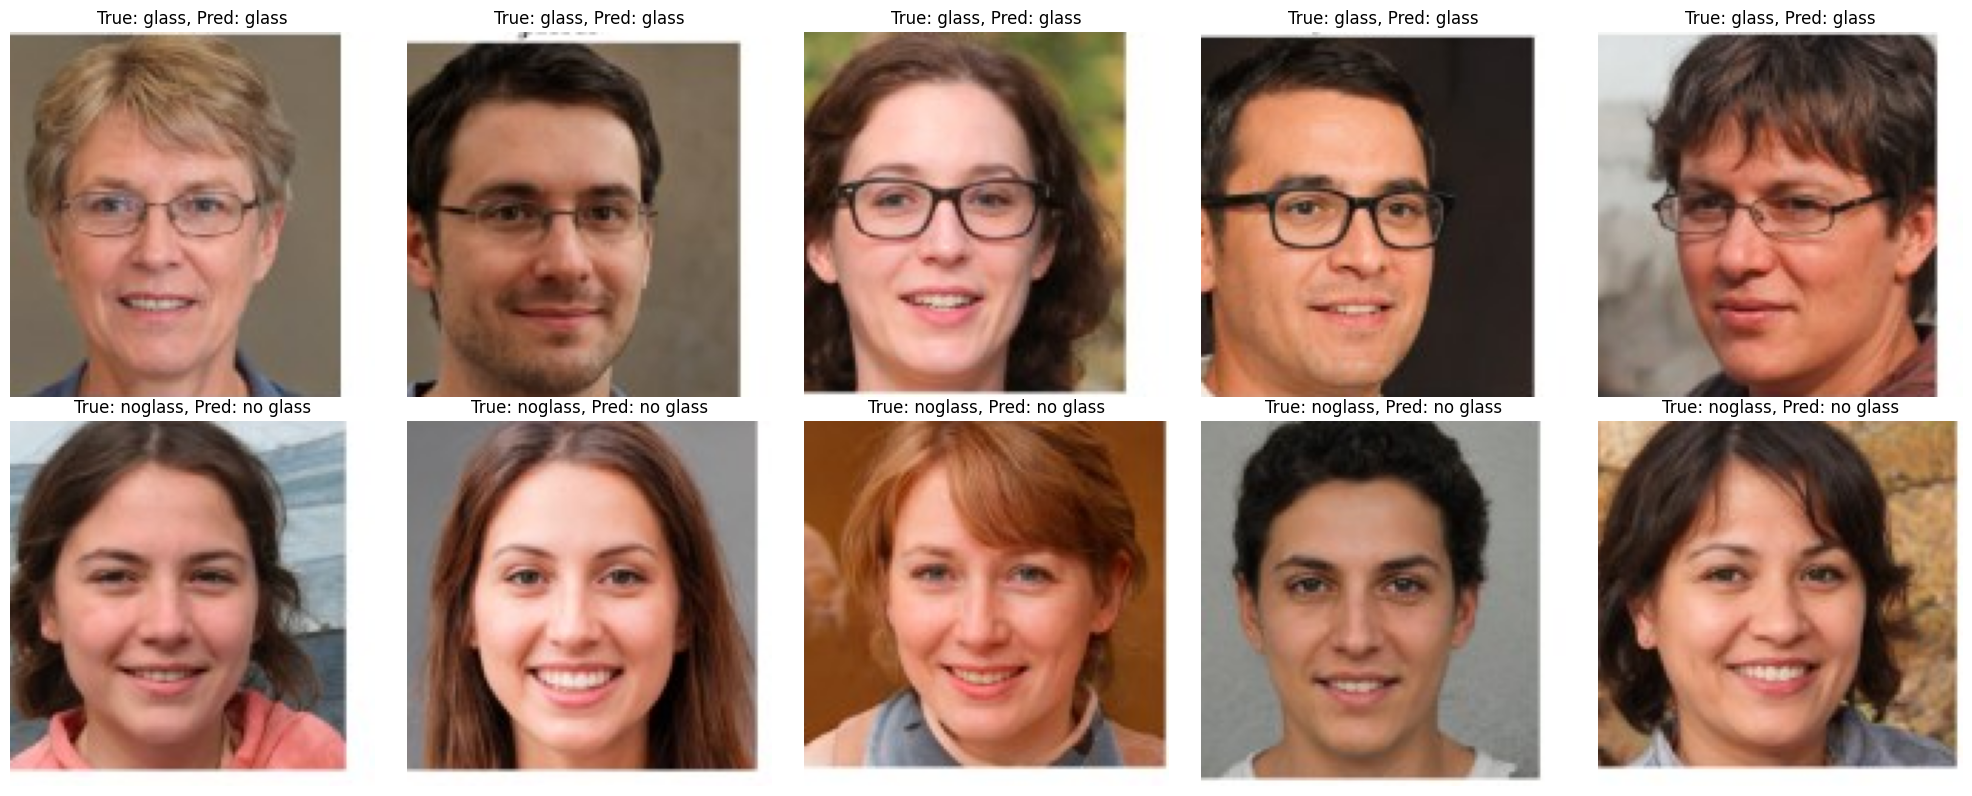

In [43]:
class_folders = {
    'glass': '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/glass/test/glasses',
    'noglass': '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/glass/test/noglasses'
}

plt.figure(figsize=(20, 8))

counter = 1

for class_name, folder_path in class_folders.items():
# class_name에는 'glass', 'noglass'가, folder_path에는 그에 해당하는 경로가 들어간다.
    image_paths = glob.glob(os.path.join(folder_path, "*"))  # 해당 클래스 폴더 내 이미지 파일들을 전부 가져온 후,
    selected_paths = image_paths[:5]  # 앞의 5개 이미지만 선택

    for image_path in selected_paths:
        image, image_cropped = load_and_transform_image(image_path, transform)
        # 중심 crop(128*128), transform 적용, PIL 이미지와 텐서 형식을 모두 반환
        image_unsqueeze = image.unsqueeze(0)
        # 변환되어 있는 것. 맨 앞에 차원이 추가 된다.
        # PyTorch 모델은 배치 차원(batch dimension) 을 요구하므로,unsqueeze(0)으로 [C, H, W] → [1, C, H, W] 형태로 변경
        image_unsqueeze = image_unsqueeze.to(device)
        output = model(image_unsqueeze)   # 추론
        _, predicted = torch.max(output, 1)   # 모델 출력(output) 중 가장 높은 확률을 가진 클래스 선택
        prediction = 'glass' if predicted.item() == 0 else 'no glass'

        plt.subplot(2, 5, counter)
        plt.imshow(image_cropped)
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')
        counter += 1

plt.tight_layout()
plt.show()